In [ ]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

## Architecture class

In [ ]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Data Generation

In [ ]:
def download_data(localfolder=''):
    filenames = ['Testing.zip', 'Training.zip']
    for filename in filenames:
        try:
            os.mkdir(f'{localfolder}{filename[:-4]}')

            localfile = f'{localfolder}{filename}'
            url = 'https://www.kaggle.com/api/v1/datasets/download/alaminbhuyan/mri-image-data'
            r = requests.get(url.format(filename), allow_redirects=True)
            open(localfile, 'wb').write(r.content)
            with zipfile.ZipFile(localfile, 'r') as zip_ref:
                zip_ref.extractall(localfolder)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
            else:
                print(f'{filename[:-4]} folder already exists!')

In [ ]:
download_data()

In [ ]:
def figure1(folder='CleandMRIImageData'):
    Glioma = Image.open(f'{folder}/Testing/glioma/Te-glTr_0000.jpg')
    Meningioma = Image.open(f'{folder}/Testing/meningioma/Te-meTr_0000.jpg')
    Normal = Image.open(f'{folder}/Testing/notumor/Te-noTr_0000.jpg')
    Pituitary = Image.open(f'{folder}/Testing/pituitary/Te-piTr_0000.jpg')

    images = [Glioma, Meningioma, Normal, Pituitary]
    titles = ['Glioma', 'Meningioma', 'Noormal', 'Pituitary']

    fig, axs = plt.subplots(1, 4, figsize=(12, 5))
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

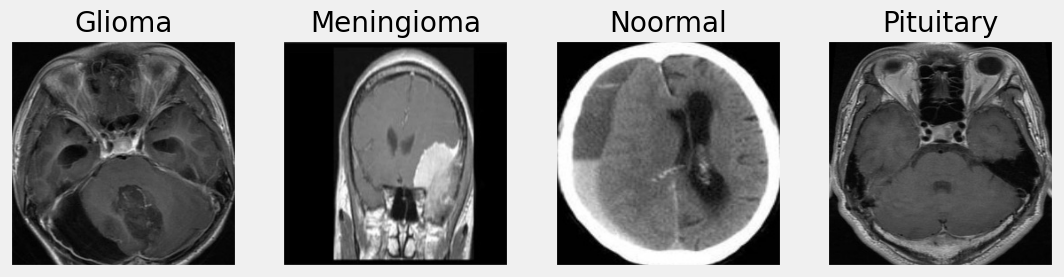

In [ ]:
fig = figure1()

# Data Preparation

## ImageFolder

In [ ]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize(size=(28, 28)),             # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'Train' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(root='CleandMRIImageData/Training',transform=temp_transform)         # Apply the preprocessing pipeline to every image

In [ ]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [ ]:
temp_dataset[0][0]

Image([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0078],
        [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
        [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0118],
        ...,
        [0.0118, 0.0118, 0.0157,  ..., 0.1216, 0.0235, 0.0118],
        [0.0118, 0.0118, 0.0157,  ..., 0.0157, 0.0118, 0.0118],
        [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118]],

       [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0078],
        [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
        [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0118],
        ...,
        [0.0118, 0.0118, 0.0157,  ..., 0.1216, 0.0235, 0.0118],
        [0.0118, 0.0118, 0.0157,  ..., 0.0157, 0.0118, 0.0118],
        [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118]],

       [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0078],
        [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
        [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0118],
        ..

In [ ]:
# you have 2520 images
temp_dataset[5711][0].shape

torch.Size([3, 28, 28])

In [ ]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 5712 images
Number of classes: 4


## Standardization

In [ ]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [ ]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 3.4340,  3.4340,  3.4340],
        [ 1.5073,  1.5073,  1.5073]])

In [ ]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[5712.0000, 5712.0000, 5712.0000],
        [1572.6479, 1572.6670, 1572.9084],
        [ 748.5095,  748.5289,  748.6597]])

In [ ]:
2142.5356/2520

0.8502125396825397

In [ ]:
526.3025/2520

0.20885019841269842

In [ ]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.2753), tensor(0.2753), tensor(0.2754)], std=[tensor(0.1310), tensor(0.1310), tensor(0.1311)], inplace=False)

## The Real Datasets

In [ ]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize(28),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'rps' contains subfolders per class for training
# - 'rps-test-set' likewise for validation
train_data = ImageFolder(root='CleandMRIImageData/Training', transform=composer)
val_data   = ImageFolder(root='CleandMRIImageData/Testing', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

In [ ]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Glioma', 'Meningioma', 'Normal', 'Pituitary']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

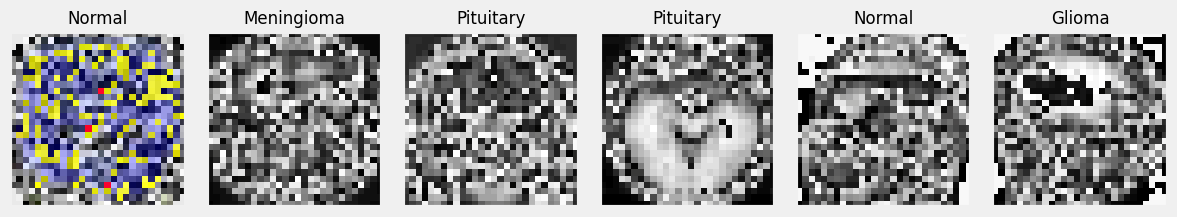

In [ ]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

# Fancier Model

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Adjusted input features for the first linear layer based on the output of featurizer
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50) # Adjusted input features
        self.fc2 = nn.Linear(50, 4)
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
         # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Added a new convolutional block
        # Input dimension (n_feature@1x1)
        # Output dimension (n_feature * 1 * 1)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 3 * 3) - Adjusted this comment
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (4)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Model Configuration

In [ ]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=10, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

In [ ]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

In [ ]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

Quantidade de parametros do modelo

In [ ]:
arch_cnn2.count_parameters()

13944

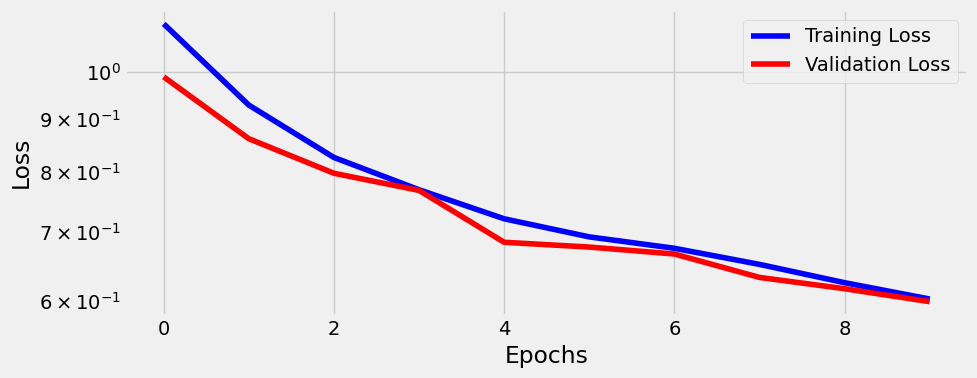

In [ ]:
fig = arch_cnn2.plot_losses()

### Accuracy

In [ ]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[232, 300],
        [152, 306],
        [375, 405],
        [261, 300]])

In [ ]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([1020, 1311])

In [ ]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.7780320366132724

### Matriz de Confusão

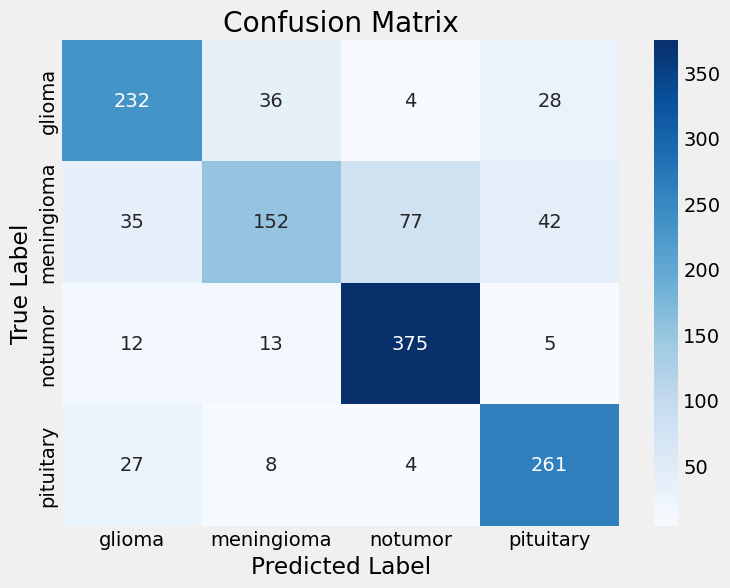

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode
arch_cnn2.model.eval()

all_preds = []
all_labels = []

# Iterate over the validation data
with torch.no_grad(): # No need to calculate gradients during evaluation
    for inputs, labels in val_loader:
        inputs = inputs.to(arch_cnn2.device)
        labels = labels.to(arch_cnn2.device)

        # Get predictions
        outputs = arch_cnn2.model(inputs)
        _, preds = torch.max(outputs, 1) # Get the predicted class index

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names
class_names = val_data.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Visualizing Filters

In [ ]:
model_cnn2.conv1.weight.shape

torch.Size([10, 3, 3, 3])

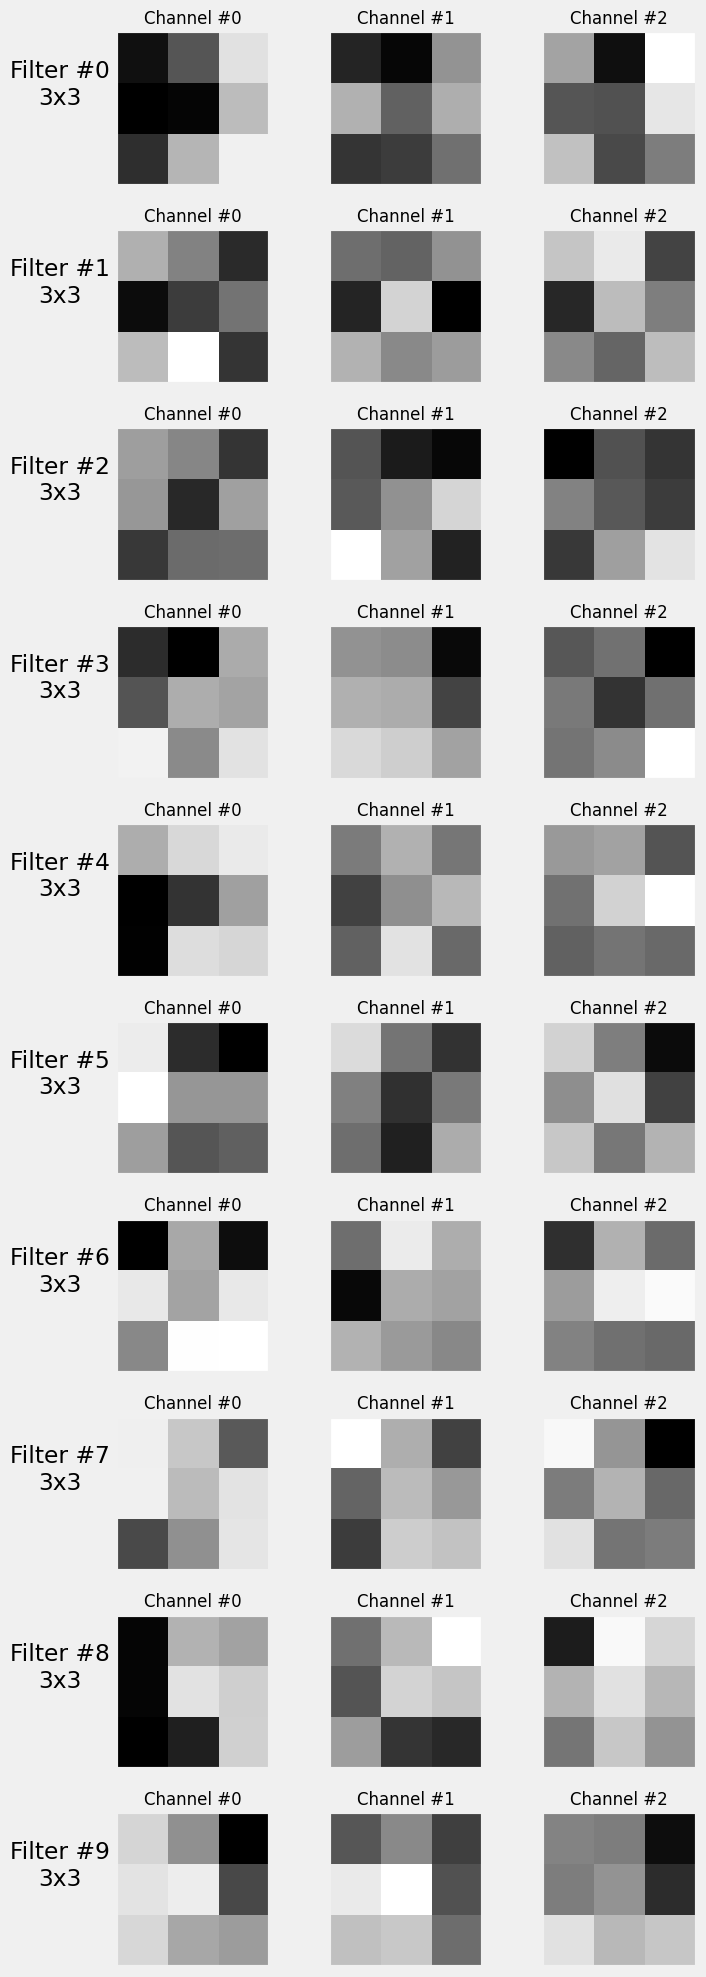

In [ ]:
fig = arch_cnn2.visualize_filters('conv1')

In [ ]:
model_cnn2.conv2.weight.shape

torch.Size([10, 10, 3, 3])

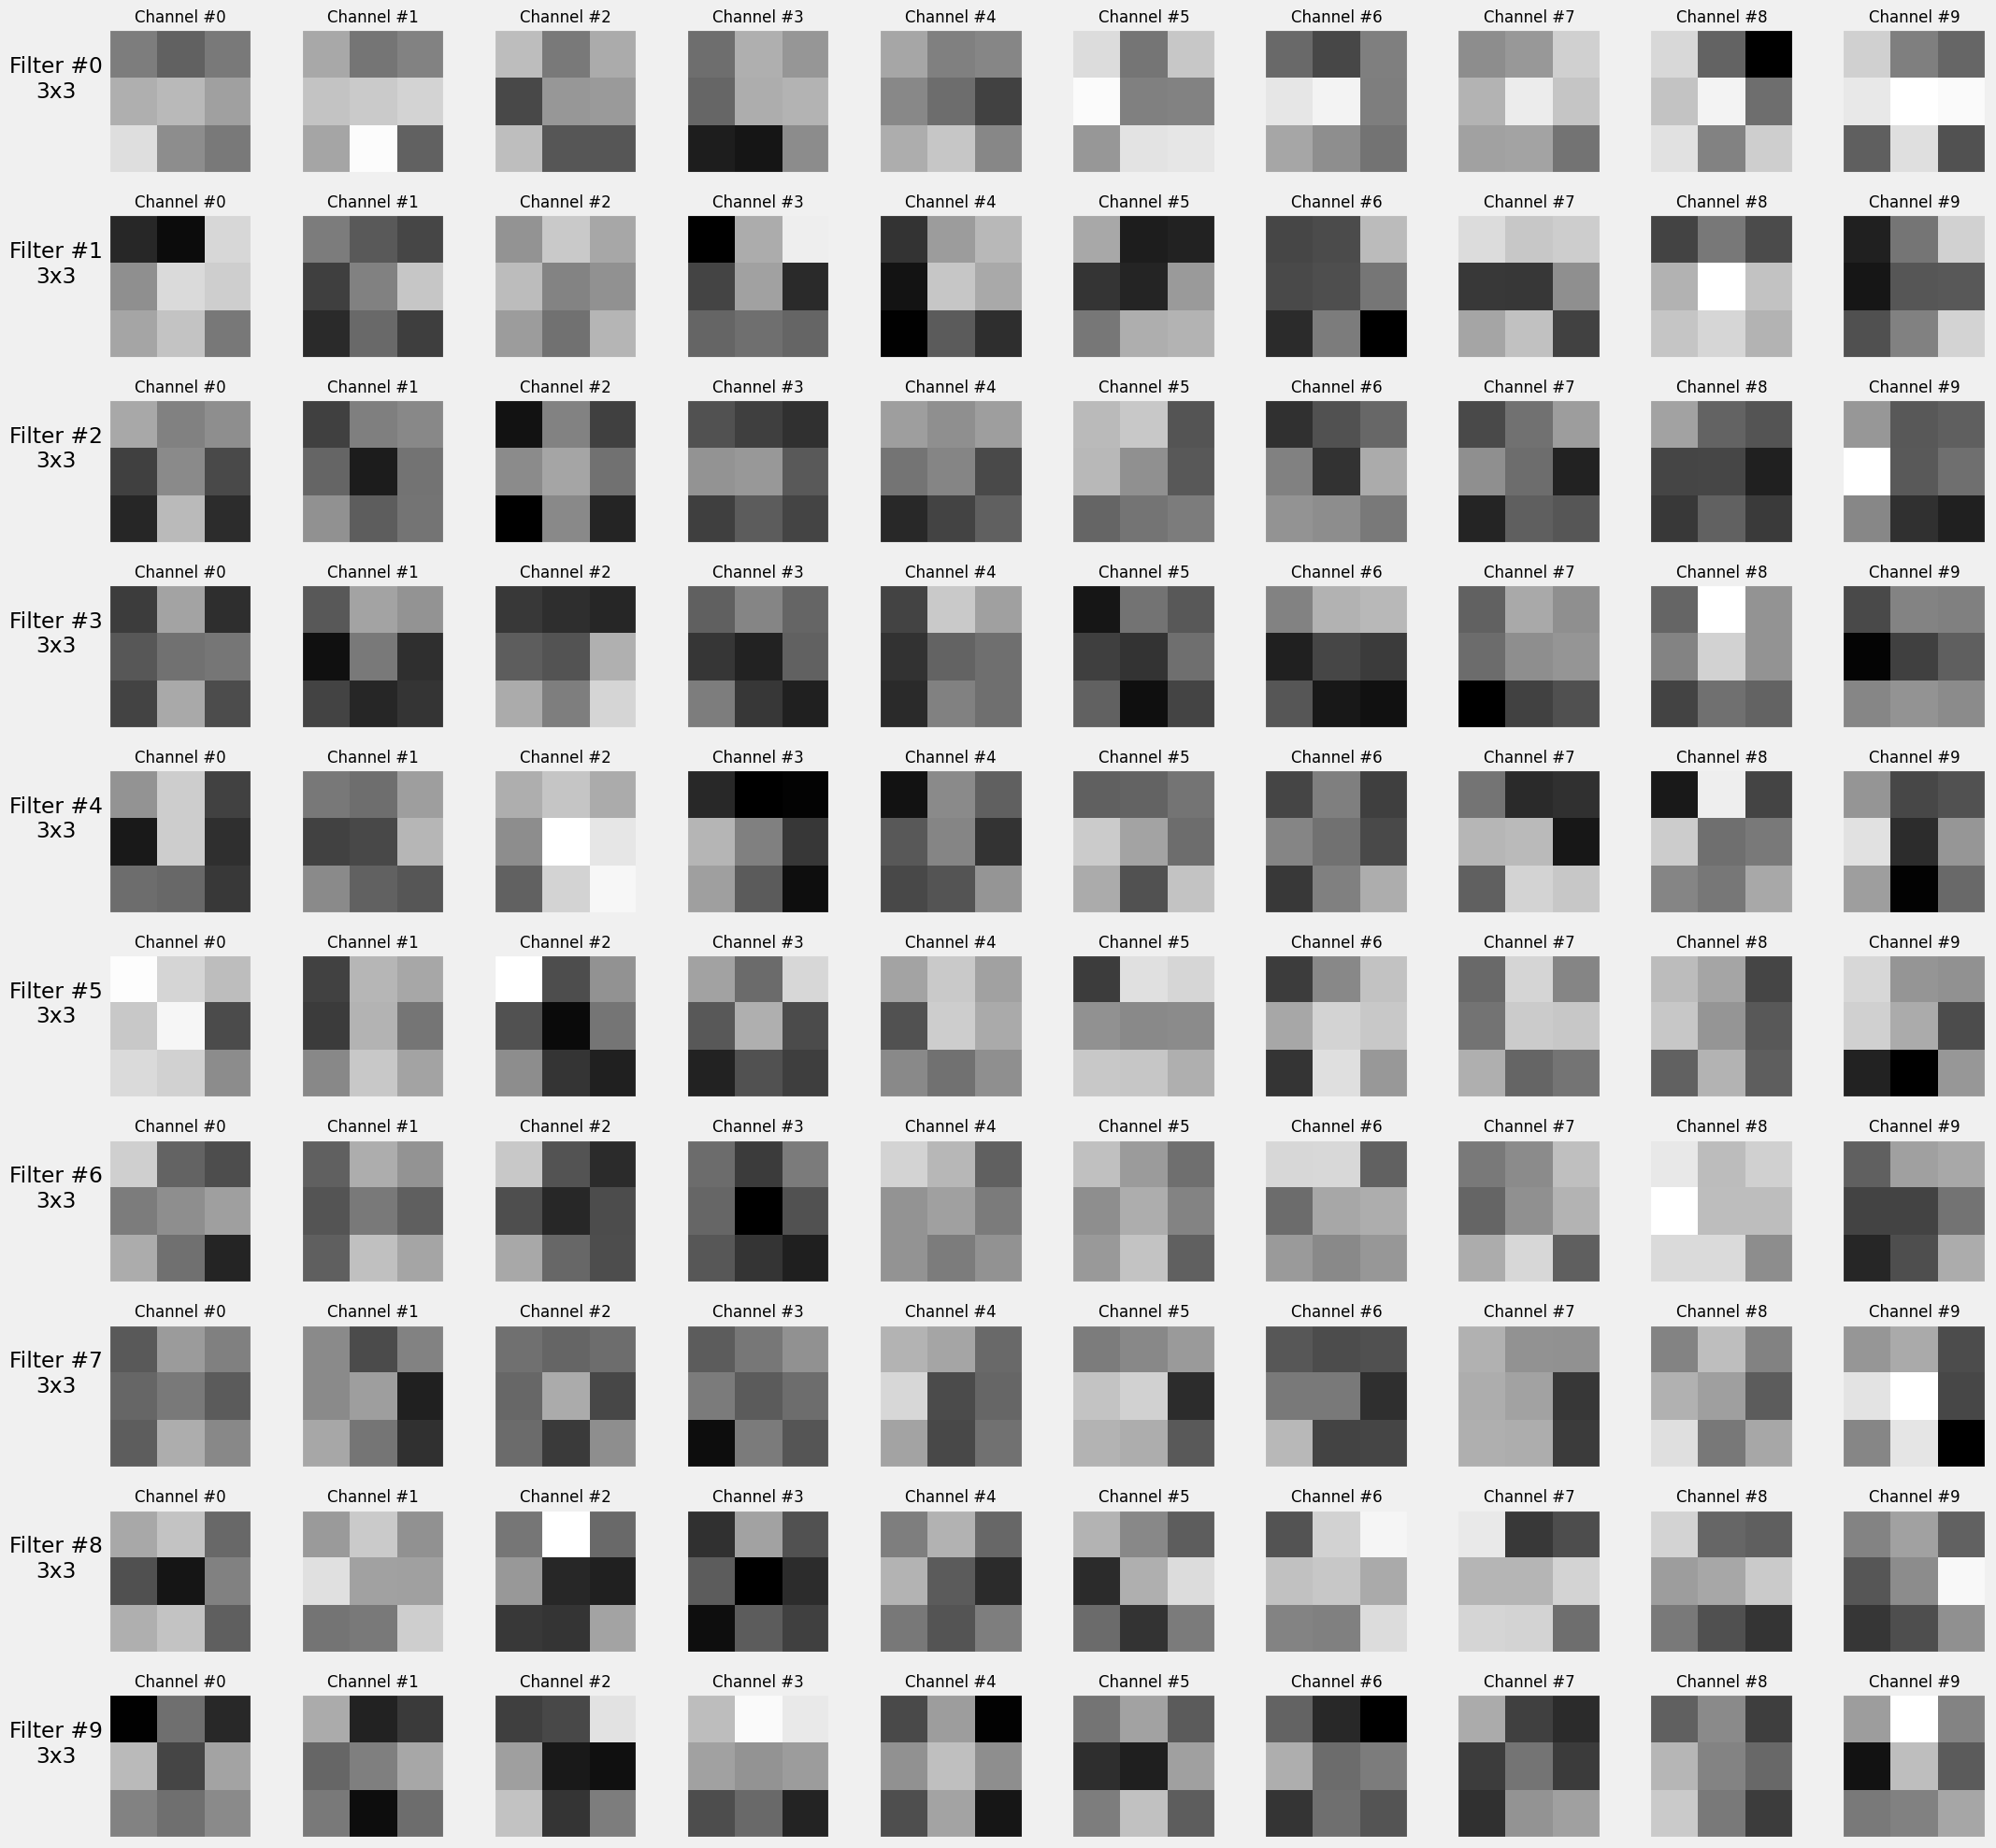

In [ ]:
fig = arch_cnn2.visualize_filters('conv2')